In [0]:
import torch
import numpy as np

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler



batch_size = 20
valid_size = 0.2

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


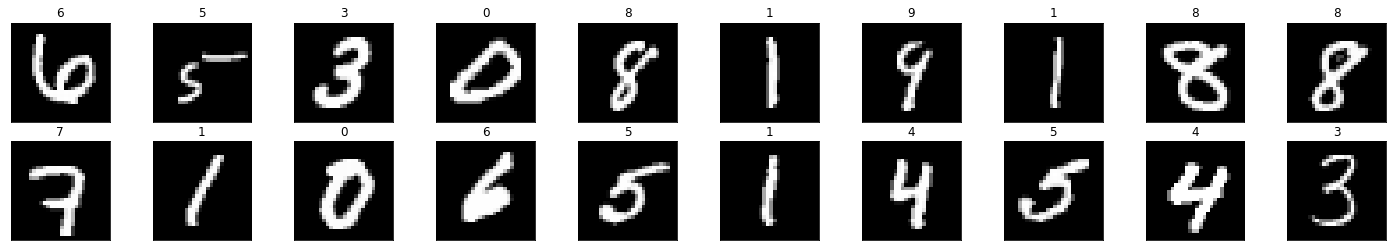

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


fig = plt.figure(figsize=(25,4))


for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str((labels[idx].item())))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        n_inputs = 28*28
        n_hidden_1 = 512
        n_hidden_2 = 512
        n_outputs = 10


        self.fc1 = nn.Linear(n_inputs, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_outputs)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):

        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [0]:
n_epochs = 50
valid_loss_min = np.Inf 

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Train The Model #
    ###################

    model.train() 
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################
    # Validate The Model #
    ######################

    model.eval() 
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)


    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.629663 	Validation Loss: 0.308309
Validation loss decreased (inf --> 0.308309).  Saving model ...
Epoch: 2 	Training Loss: 0.292958 	Validation Loss: 0.234967
Validation loss decreased (0.308309 --> 0.234967).  Saving model ...
Epoch: 3 	Training Loss: 0.225406 	Validation Loss: 0.209879
Validation loss decreased (0.234967 --> 0.209879).  Saving model ...
Epoch: 4 	Training Loss: 0.183222 	Validation Loss: 0.156405
Validation loss decreased (0.209879 --> 0.156405).  Saving model ...
Epoch: 5 	Training Loss: 0.154762 	Validation Loss: 0.135187
Validation loss decreased (0.156405 --> 0.135187).  Saving model ...
Epoch: 6 	Training Loss: 0.134235 	Validation Loss: 0.121341
Validation loss decreased (0.135187 --> 0.121341).  Saving model ...
Epoch: 7 	Training Loss: 0.118047 	Validation Loss: 0.111329
Validation loss decreased (0.121341 --> 0.111329).  Saving model ...
Epoch: 8 	Training Loss: 0.106053 	Validation Loss: 0.100472
Validation loss decreased (0.11132

In [0]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [0]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in test_loader:

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))


    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.057037

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1020/1032)
Test Accuracy of     3: 98% (998/1010)
Test Accuracy of     4: 98% (964/982)
Test Accuracy of     5: 97% (871/892)
Test Accuracy of     6: 98% (943/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 98% (961/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 98% (9840/10000)


20


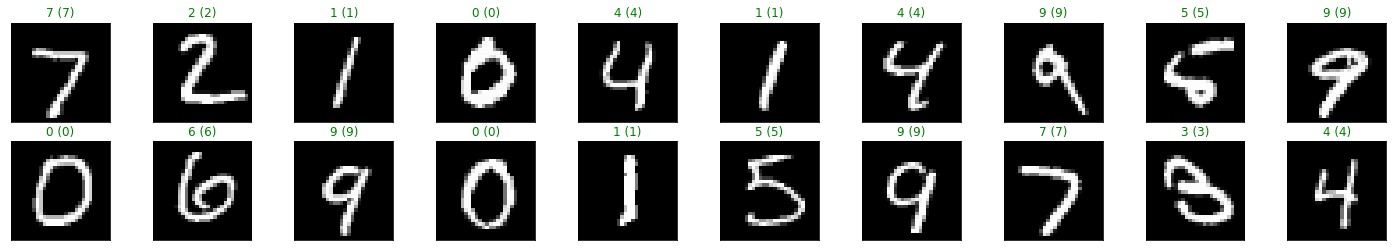

In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

print(len(images))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))